In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# **Load the data**

In [2]:
train_df = pd.read_csv('../input/titanic/train.csv')

In [3]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test_df = pd.read_csv('../input/titanic/test.csv')

In [5]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# **Data Training**

**1. Exploratory Data Analysis**

<AxesSubplot:>

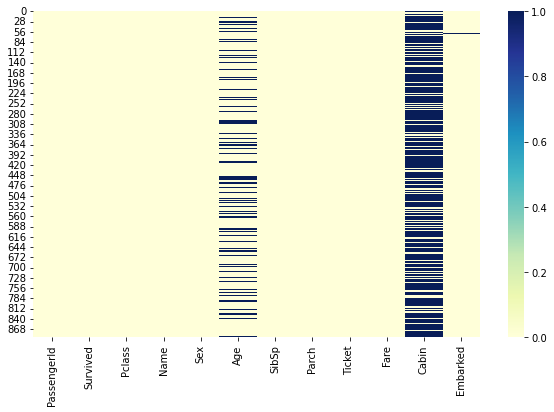

In [6]:
plt.figure(figsize=(10,6))
sns.heatmap(train_df.isnull(), cmap='YlGnBu')

<AxesSubplot:xlabel='Survived', ylabel='count'>

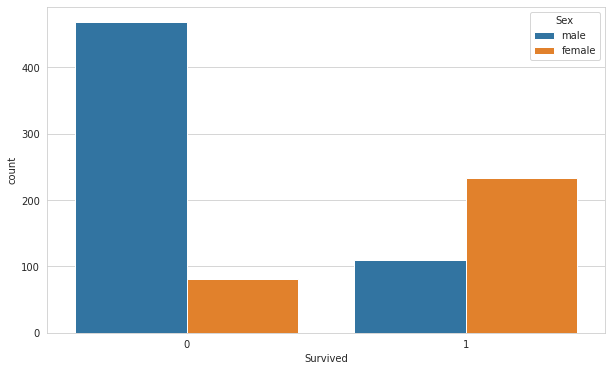

In [7]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
sns.countplot(data=train_df, x='Survived', hue='Sex')

Female passengers are more likely to survive

<AxesSubplot:xlabel='Survived', ylabel='count'>

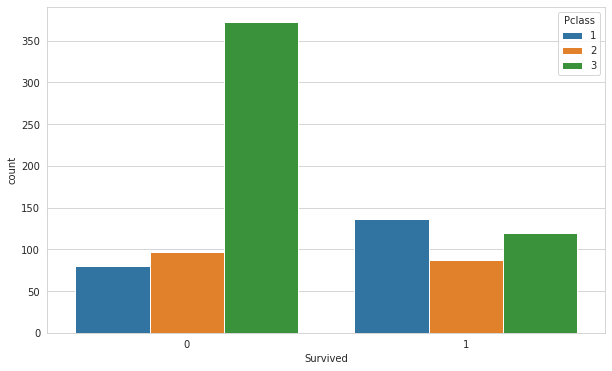

In [8]:
plt.figure(figsize=(10,6))
sns.countplot(data=train_df, x='Survived', hue='Pclass')

3rd class passengers have more chances of not survive

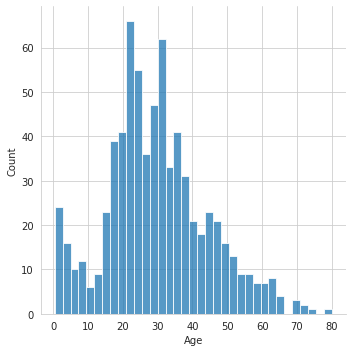

In [9]:
sns.displot(train_df['Age'].dropna(), kde=False, bins=35)

<AxesSubplot:xlabel='SibSp', ylabel='count'>

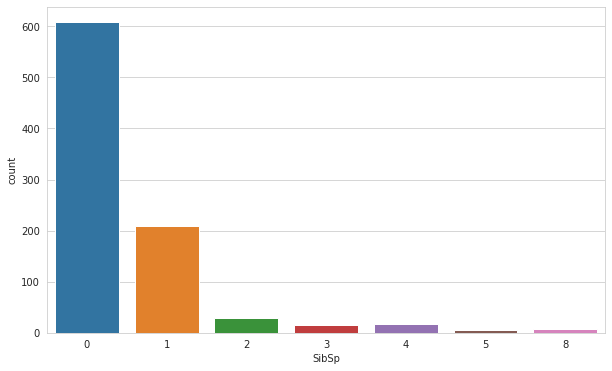

In [10]:
plt.figure(figsize=(10,6))
sns.countplot(data=train_df, x='SibSp')

<AxesSubplot:xlabel='Pclass', ylabel='Age'>

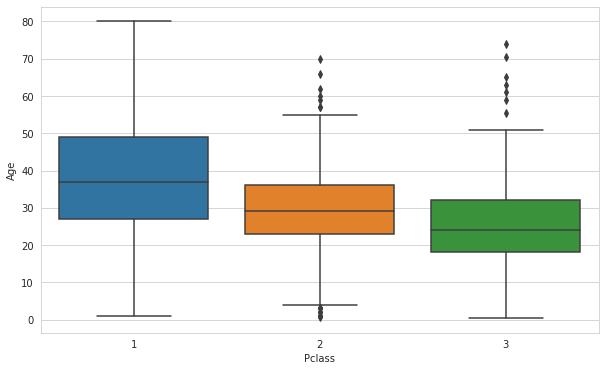

In [11]:
plt.figure(figsize=(10,6))
sns.boxplot(data=train_df, x='Pclass', y='Age')

<AxesSubplot:xlabel='Age', ylabel='Fare'>

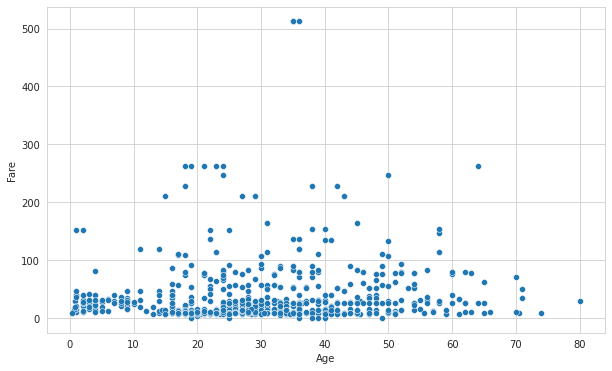

In [12]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=train_df, x='Age', y='Fare')

**2. Fill the missing values**

In [13]:
age_by_class = train_df.groupby('Pclass')['Age'].mean()
age_by_class

Pclass
1    38.233441
2    29.877630
3    25.140620
Name: Age, dtype: float64

In [14]:
def fill_age(x):
    Age = x[0]
    Pclass = x[1]
    if pd.isnull(Age):
        if(Pclass==1):
            return 38
        elif(Pclass==2):
            return 30
        else:
            return 25
    return Age

In [15]:
train_df['Age'] = train_df[['Age', 'Pclass']].apply(fill_age, axis=1)

In [16]:
train_df = train_df.drop('Cabin', axis=1)

In [17]:
train_df = train_df.dropna()

<AxesSubplot:>

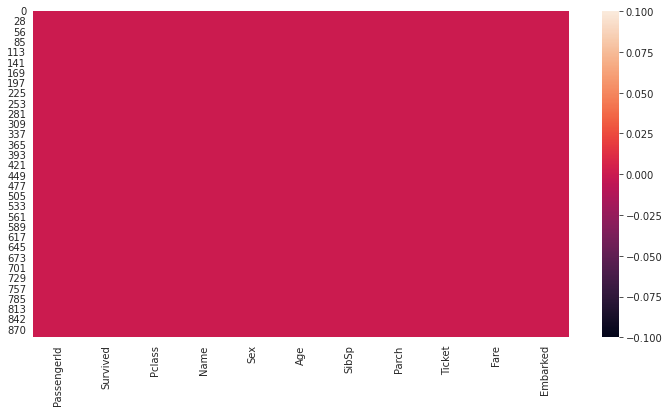

In [18]:
plt.figure(figsize=(12,6))
sns.heatmap(train_df.isnull())

**Dummies for the categorized feature**

In [19]:
train_df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [20]:
embarked_dummies = pd.get_dummies(train_df['Embarked'], drop_first=True)
embarked_dummies

,Q,S
0,0,1
1,0,0
2,0,1
3,0,1
4,0,1
...,...,...
886,0,1
887,0,1
888,0,1
889,0,0


In [21]:

sex_dummies = pd.get_dummies(train_df['Sex'], drop_first=True)
sex_dummies

,male
0,1
1,0
2,0
3,0
4,1
...,...
886,1
887,0
888,0
889,1


In [22]:
train_df = pd.concat([train_df.drop(['Embarked','Sex','Name','Ticket'],axis=1),embarked_dummies, sex_dummies],axis=1)
train_df

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Q,S,male
0,1,0,3,22.0,1,0,7.2500,0,1,1
1,2,1,1,38.0,1,0,71.2833,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,1,0
3,4,1,1,35.0,1,0,53.1000,0,1,0
4,5,0,3,35.0,0,0,8.0500,0,1,1
...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,27.0,0,0,13.0000,0,1,1
887,888,1,1,19.0,0,0,30.0000,0,1,0
888,889,0,3,25.0,1,2,23.4500,0,1,0
889,890,1,1,26.0,0,0,30.0000,0,0,1


# **Data Testing**

**1. Fill the missing values**

<AxesSubplot:>

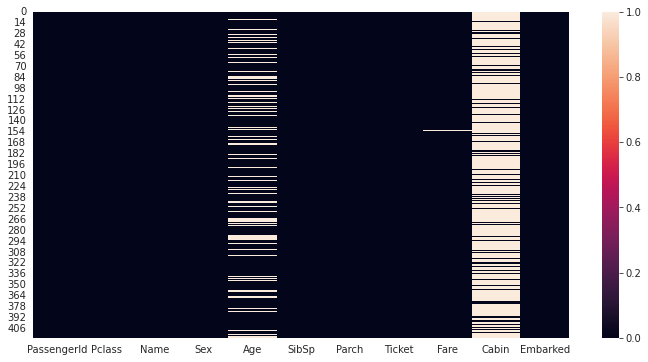

In [23]:
plt.figure(figsize=(12,6))
sns.heatmap(test_df.isnull())

In [24]:
test_df['Age'] = test_df[['Age','Pclass']].apply(fill_age, axis=1)

In [25]:
test_df = test_df.drop('Cabin', axis=1)

In [26]:
test_df = test_df.fillna(test_df['Fare'].mean())

<AxesSubplot:>

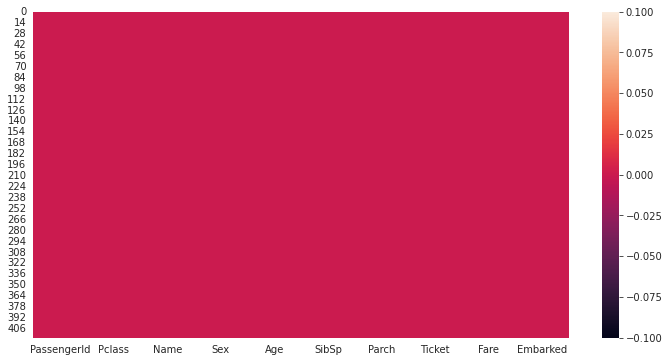

In [27]:
plt.figure(figsize=(12,6))
sns.heatmap(test_df.isnull())

**2. Dummies for categorized feature**

In [28]:
test_df['Embarked'].value_counts()

S    270
C    102
Q     46
Name: Embarked, dtype: int64

In [29]:
embarked_dummies_test = pd.get_dummies(test_df['Embarked'], drop_first=True)
embarked_dummies_test

,Q,S
0,1,0
1,0,1
2,1,0
3,0,1
4,0,1
...,...,...
413,0,1
414,0,0
415,0,1
416,0,1


In [30]:
sex_dummies_test = pd.get_dummies(test_df['Sex'], drop_first=True)
sex_dummies_test

,male
0,1
1,0
2,1
3,1
4,0
...,...
413,1
414,0
415,1
416,1


In [31]:
test_df = pd.concat([test_df.drop(['Embarked','Sex','Name','Ticket'],axis=1),embarked_dummies_test, sex_dummies_test],axis=1)
test_df

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Q,S,male
0,892,3,34.5,0,0,7.8292,1,0,1
1,893,3,47.0,1,0,7.0000,0,1,0
2,894,2,62.0,0,0,9.6875,1,0,1
3,895,3,27.0,0,0,8.6625,0,1,1
4,896,3,22.0,1,1,12.2875,0,1,0
...,...,...,...,...,...,...,...,...,...
413,1305,3,25.0,0,0,8.0500,0,1,1
414,1306,1,39.0,0,0,108.9000,0,0,0
415,1307,3,38.5,0,0,7.2500,0,1,1
416,1308,3,25.0,0,0,8.0500,0,1,1


# **Modelling**

In [32]:
y = train_df['Survived']
features = ['Pclass','Age','SibSp','Parch','Fare','Q','S','male']
X = train_df[features]
X_test = test_df[features]

In [33]:
from sklearn.svm import SVC

In [34]:
svc_model = SVC()

In [35]:
svc_model.fit(X, y)

SVC()

In [36]:
predictions = svc_model.predict(X_test)

In [37]:
output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print("Saved!")

Saved!


In [38]:
output_df = pd.read_csv('./submission.csv')

In [39]:
output_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
